In [2]:
import pandas as pd
import numpy as np
import os

# create ../data relative to the notebook folder
os.makedirs("../data", exist_ok=True)

dates = pd.date_range("2020-01-01", "2023-12-31", freq="D")
countries = ["Saudi Arabia", "USA", "Russia", "Iraq", "UAE"]

np.random.seed(42)
rows = []

base_map = {
    "Saudi Arabia": 9_000_000,
    "USA": 8_000_000,
    "Russia": 7_500_000,
    "Iraq": 4_500_000,
    "UAE": 3_500_000
}

for d in dates:
    for c in countries:
        base = base_map[c]
        seasonal = np.sin(d.dayofyear / 365 * 2 * np.pi) * 200_000
        noise = np.random.normal(0, 150_000)
        barrels = max(0, base + seasonal + noise)
        vessel_count = max(1, barrels / 200_000)

        rows.append([d, c, "Global", round(barrels), round(vessel_count)])

flows = pd.DataFrame(
    rows,
    columns=["date", "origin_country", "destination_region", "barrels", "vessel_count"]
)

brent = pd.DataFrame({
    "date": dates,
    "brent_usd": 70 + np.sin(np.arange(len(dates))/180)*10 + np.random.normal(0, 2, len(dates))
})

flows.to_csv("../data/sample_flows.csv", index=False)
brent.to_csv("../data/brent_prices.csv", index=False)

print("✅ Created: ../data/sample_flows.csv and ../data/brent_prices.csv")
print("Preview flows:")
print(flows.head())
print("\nPreview brent:")
print(brent.head())


✅ Created: ../data/sample_flows.csv and ../data/brent_prices.csv
Preview flows:
        date origin_country destination_region  barrels  vessel_count
0 2020-01-01   Saudi Arabia             Global  9077950            45
1 2020-01-01            USA             Global  7982703            40
2 2020-01-01         Russia             Global  7600596            38
3 2020-01-01           Iraq             Global  4731897            24
4 2020-01-01            UAE             Global  3468320            17

Preview brent:
        date  brent_usd
0 2020-01-01  63.910687
1 2020-01-02  72.098826
2 2020-01-03  72.983845
3 2020-01-04  68.066286
4 2020-01-05  68.277607


In [3]:
import os
print("Notebook folder:", os.getcwd())
print("Project root contains:", os.listdir(".."))
print("Data folder contains:", os.listdir("../data"))


Notebook folder: C:\Users\barakou.a\Downloads\global-oil-flow-intelligence-main\global-oil-flow-intelligence-main\notebooks
Project root contains: ['.gitignore', '.ipynb_checkpoints', 'data', 'LICENSE', 'notebooks', 'README.md', 'requirements.txt']
Data folder contains: ['brent_prices.csv', 'sample_flows.csv']


In [4]:
import pandas as pd

flows = pd.read_csv("../data/sample_flows.csv", parse_dates=["date"])
brent = pd.read_csv("../data/brent_prices.csv", parse_dates=["date"])

print(flows.shape, brent.shape)
flows.head()


(7305, 5) (1461, 2)


,date,origin_country,destination_region,barrels,vessel_count
0,2020-01-01,Saudi Arabia,Global,9077950,45
1,2020-01-01,USA,Global,7982703,40
2,2020-01-01,Russia,Global,7600596,38
3,2020-01-01,Iraq,Global,4731897,24
4,2020-01-01,UAE,Global,3468320,17


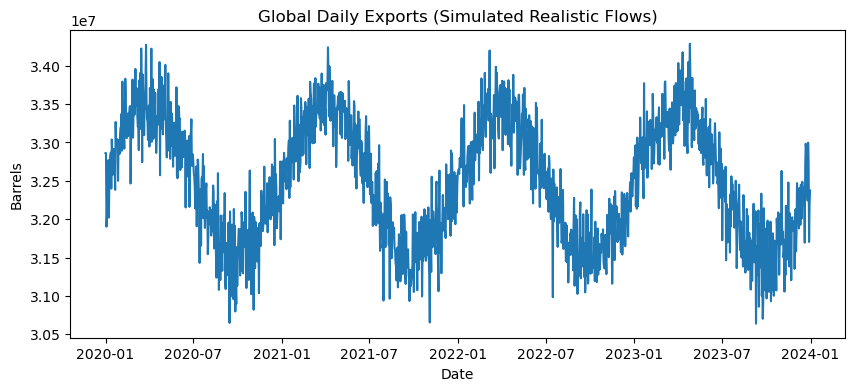

In [5]:
import matplotlib.pyplot as plt

daily_exports = flows.groupby("date", as_index=False)["barrels"].sum()

plt.figure(figsize=(10,4))
plt.plot(daily_exports["date"], daily_exports["barrels"])
plt.title("Global Daily Exports (Simulated Realistic Flows)")
plt.xlabel("Date")
plt.ylabel("Barrels")
plt.show()


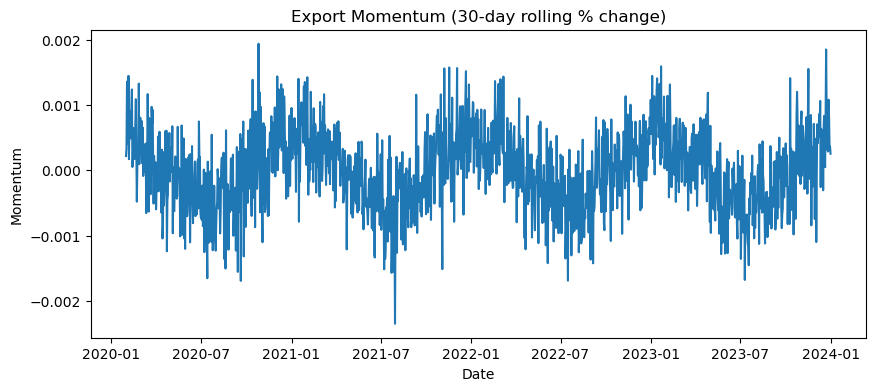

,date,barrels,rolling_30,momentum
1456,2023-12-27,32996790,3.221640e+07,0.001080
1457,2023-12-28,32735463,3.224179e+07,0.000788
1458,2023-12-29,31703892,3.225352e+07,0.000364
1459,2023-12-30,32198328,3.226521e+07,0.000362
1460,2023-12-31,32374386,3.227335e+07,0.000252


In [6]:
daily_exports["rolling_30"] = daily_exports["barrels"].rolling(30).mean()
daily_exports["momentum"] = daily_exports["rolling_30"].pct_change()

plt.figure(figsize=(10,4))
plt.plot(daily_exports["date"], daily_exports["momentum"])
plt.title("Export Momentum (30-day rolling % change)")
plt.xlabel("Date")
plt.ylabel("Momentum")
plt.show()

daily_exports[["date","barrels","rolling_30","momentum"]].tail()


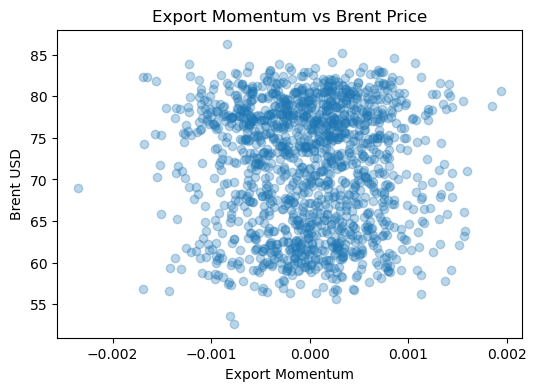

Correlation: -0.017648462238679392


In [7]:
merged = pd.merge(daily_exports, brent, on="date", how="inner")

plt.figure(figsize=(6,4))
plt.scatter(merged["momentum"], merged["brent_usd"], alpha=0.3)
plt.title("Export Momentum vs Brent Price")
plt.xlabel("Export Momentum")
plt.ylabel("Brent USD")
plt.show()

print("Correlation:", merged["momentum"].corr(merged["brent_usd"]))


In [10]:
merged["flow_shift_alert"] = merged["momentum"] < -0.10

alerts = merged[merged["flow_shift_alert"]].copy()
print("Number of alert days:", len(alerts))
alerts[["date","momentum","brent_usd"]].head(10)


Number of alert days: 0


,date,momentum,brent_usd


In [12]:
threshold = merged["momentum"].mean() - 2 * merged["momentum"].std()

merged["flow_shift_alert"] = merged["momentum"] < threshold

alerts = merged[merged["flow_shift_alert"]]

print("Threshold:", threshold)
print("Number of alert days:", len(alerts))
alerts[["date","momentum","brent_usd"]].head()



Threshold: -0.00122142333503734
Number of alert days: 34


,date,momentum,brent_usd
113,2020-04-23,-0.001241,75.833640
189,2020-07-08,-0.001253,76.555809
195,2020-07-14,-0.001653,82.286628
206,2020-07-25,-0.001224,83.914480
212,2020-07-31,-0.001231,78.742892


In [13]:
merged["price_change"] = merged["brent_usd"].pct_change()

merged["tight_supply_signal"] = (
    (merged["momentum"] < 0) &
    (merged["price_change"] > 0)
)

tight_supply = merged[merged["tight_supply_signal"]]

print("Number of tight supply days:", len(tight_supply))
tight_supply[["date","momentum","price_change","brent_usd"]].head(10)


Number of tight supply days: 348


,date,momentum,price_change,brent_usd
65,2020-03-06,-0.000088,0.020432,73.950846
69,2020-03-10,-0.000020,0.068855,74.681106
80,2020-03-21,-0.000366,0.015951,74.927823
88,2020-03-29,-0.000303,0.027411,74.006244
89,2020-03-30,-0.000372,0.011179,74.833552
91,2020-04-01,-0.000598,0.091357,77.620265
94,2020-04-04,-0.000207,0.026638,77.719127
96,2020-04-06,-0.000324,0.033294,76.232149
100,2020-04-10,-0.000121,0.066812,78.605360
102,2020-04-12,-0.000649,0.029461,76.767156


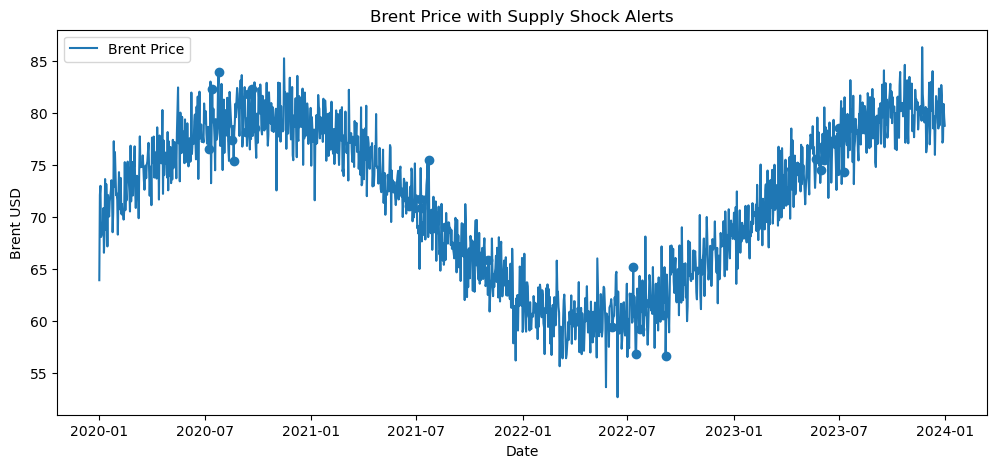

In [14]:
plt.figure(figsize=(12,5))

plt.plot(merged["date"], merged["brent_usd"], label="Brent Price")

# Highlight supply shock days
shock_days = merged[merged["flow_shift_alert"]]

plt.scatter(
    shock_days["date"],
    shock_days["brent_usd"],
    marker="o"
)

plt.title("Brent Price with Supply Shock Alerts")
plt.xlabel("Date")
plt.ylabel("Brent USD")
plt.legend()
plt.show()
